# <font color='red'>MDI341 - Large Scale Face Classification</font>

In [1]:
# Data manip
import pandas as pd
import numpy as np
import random
# Vizu
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
# Basic
import glob, os, re
from collections import Counter
# Image manip
import cv2 as cv
from google.colab.patches import cv2_imshow

# TF
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation, Resizing
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, AveragePooling2D, Add, BatchNormalization, Dropout, UpSampling2D, Activation, concatenate, ZeroPadding2D, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Keras
import keras
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
# Imgaug lib
import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.947622203000037
GPU (s):
0.03352924000000712
GPU speedup over CPU: 87x
Num GPUs Available:  1


1. [Introduction](#Introduction)

2. [Feature exploration](#Features)

  2.1 [Train set](#TrainDataset)

  2.2 [Validation set](#ValidationDataset)
      
  2.3 [Preprocessing : Data Augmentation & Unbalanced class](#Preprocess)


3. [Modelisation](#DL)

  3.1 [Architectures](#Architectures)

  3.2 [Transfer Learning](#Transfer)

4. [Validation DataSet (Accuray by gender) ](#Validation)

5. [Test submission](#Submission)

5. [Conclusion](#Conclusion)

[References](#References)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **1. Introduction** <a name="Introduction"></a>

## <font color='orange'>**Goal Project**</font>

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.

  1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
  2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

## Properties of the dataset

The data set is provided by IDEMIA, a multinational security company with headquaters in France. It consistst of images of faces of different persons with certain characteristics. The task is to train a model able to predict whether certain image possess required chacteristics (encoded by the output labels) or not.
There is imbalance between the sample images in the dataset for men and women.


## Training and Validation Data

***Training Data:*** The "train" folder contains 149,943 face images numbered from 000000 to 149942. These are color images in .jpg format with size of 80x80 pixels.

***Training Labels:*** The file named "label_train.txt" contains two columns. The first column list the 149,943 labels (0 or 1) that are used to train your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

***Validation Data:*** The "validation" folder contains 24,996 face images numbered from 000000 to 024995. These are color images in .jpg format with size of 80x80 pixels.

***Validation Labels:*** The file named "label_validation.txt" contains two columns. The first column list the 24,996 labels (0 or 1) that are used to validate your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

## Test Data

 The "test" folder contains 27,596 face images numbered from 000000 to 027595. These are color images in .jpg format with size of 80x80 pixels.


 ## Remarks

 Image classification with certian unknown characteristics are difficult task. The purpose of this data challenge is to extract different characteristicts from images. So, it is important that at the end of the data challenge, you know the characteristics of the images on which this dataset is based on.


 ## The Performance Criterion:

You should submit a file that contains in each row classificaiton of images available in **test** folder. For a sample submission please see the codes below. 
To measure the performance of your model, we calculate two parameters.

1- Global Classification Error 

2- Absolute_value(Classification_Error_Men - Classification_Error_Women)

Using these two Errors, we calculate your Borda and Copeland scores which are the Ranking methods used in preferential voting. You can find the detail of these methods under the two links below.

https://en.wikipedia.org/wiki/Borda_count

https://en.wikipedia.org/wiki/Copeland%27s_method

Your final ranking is based on **Copeland score**.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip '/content/gdrive/MyDrive/Data_Challenge_MDI_341.zip'
!unzip '/content/gdrive/MyDrive/GENKI-4K.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: GENKI-4K/files/file1128.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file1128.jpg  
  inflating: GENKI-4K/files/file0236.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file0236.jpg  
  inflating: GENKI-4K/files/file2421.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file2421.jpg  
  inflating: GENKI-4K/files/file2347.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file2347.jpg  
  inflating: GENKI-4K/files/file3059.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file3059.jpg  
  inflating: GENKI-4K/files/file0550.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file0550.jpg  
  inflating: GENKI-4K/files/file1896.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file1896.jpg  
  inflating: GENKI-4K/files/file0544.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file0544.jpg  
  inflating: GENKI-4K/files/file1882.jpg  
  inflating: __MACOSX/GENKI-4K/files/._file1882.jpg  
  inflating: GENKI-4K/files/file2353.jpg  
  infl

In [10]:
TOTAL_TRAIN_SAMPLES = len(os.listdir("train"))
TOTAL_VALIDATION_SAMPLES = len(os.listdir("validation"))
TOTAL_TEST_SAMPLES = len(os.listdir("test"))
print('total training images:', TOTAL_TRAIN_SAMPLES)
print('total validation images:', TOTAL_VALIDATION_SAMPLES)
print('total test images:', TOTAL_TEST_SAMPLES)

img = cv.imread('train/000000.jpg')
FACE_SHAPE = img.shape
print('shape of the image {}'.format(FACE_SHAPE))
print('Value of the pixel {}'.format(img[40,40]))

total training images: 149983
total validation images: 24996
total test images: 27596
shape of the image (80, 80, 3)
Value of the pixel [168 199 238]


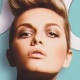

In [11]:
img = cv.imread('train/000000.jpg')
img_resize = cv.resize(img, (400,400))
cv2_imshow(img)
plt.show();

Change from RGB -> HSV

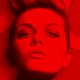

In [13]:
img_hsv = tf.image.rgb_to_hsv(img).numpy()
cv2_imshow(img_hsv)

In [15]:
print('total transfer learning images:', len(os.listdir("GENKI-4K")))
#GENKI labels
genki_labels = pd.read_csv('GENKI-4K/GENKI-4K_Labels.txt', sep = ' ', header = None, names = ['labels','1st point','2nd point','3rd point'], dtype=float)
genki_labels["labels"]
#GENKI images
genki_images = pd.read_csv('GENKI-4K/GENKI-4K_Images.txt', sep = ' ', header = None, names = ['filenames'], dtype=str)
genki_images['filenames'] = genki_images["filenames"].apply(lambda x: x[:4]+x[-8:])
genki_images["labels"] = genki_labels["labels"].astype(int)
# Copy for folder add
genki_images_copy = genki_images.copy()
genki_images_copy['filenames'] = genki_images_copy["filenames"].apply(lambda x: x[:4]+x[-8:])
genki_images_copy['filenames'] = 'GENKI-4K/files/' + genki_images_copy['filenames'].astype(str)
print(genki_images)
print(genki_images_copy)

img = cv.imread(genki_images_copy["filenames"][0])
GENKI_SHAPE = img.shape
print('shape of the image GENKI-4K{}'.format(GENKI_SHAPE))

total transfer learning images: 5
         filenames  labels
0     file0001.jpg       1
1     file0002.jpg       1
2     file0003.jpg       1
3     file0004.jpg       1
4     file0005.jpg       1
...            ...     ...
3995  file3982.jpg       0
3996  file3983.jpg       0
3997  file3984.jpg       0
3998  file3985.jpg       0
3999  file3986.jpg       0

[4000 rows x 2 columns]
                        filenames  labels
0     GENKI-4K/files/file0001.jpg       1
1     GENKI-4K/files/file0002.jpg       1
2     GENKI-4K/files/file0003.jpg       1
3     GENKI-4K/files/file0004.jpg       1
4     GENKI-4K/files/file0005.jpg       1
...                           ...     ...
3995  GENKI-4K/files/file3982.jpg       0
3996  GENKI-4K/files/file3983.jpg       0
3997  GENKI-4K/files/file3984.jpg       0
3998  GENKI-4K/files/file3985.jpg       0
3999  GENKI-4K/files/file3986.jpg       0

[4000 rows x 2 columns]
shape of the image GENKI-4K(192, 178, 3)


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **2. Feature exploration** <a name="Features"></a>

<font color='orange'>**2.1  Train set** <a name="TrainDataset"></a></font>

In this section we are looking about the training set and what we can extract on a first look

Size of train dataset : 149983
               filenames  label  genre
0       train/000000.jpg      0      0
1       train/000001.jpg      1      0
2       train/000002.jpg      1      0
3       train/000003.jpg      0      1
4       train/000004.jpg      1      1
...                  ...    ...    ...
149978  train/149978.jpg      0      1
149979  train/149979.jpg      0      0
149980  train/149980.jpg      0      0
149981  train/149981.jpg      0      0
149982  train/149982.jpg      0      1

[149983 rows x 3 columns]
0    0.582839
1    0.417161
Name: genre, dtype: float64



0    0.530947
1    0.469053
Name: label, dtype: float64


No duplicate label for same image training : True




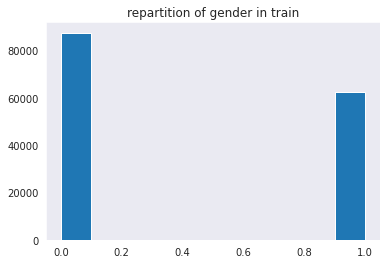

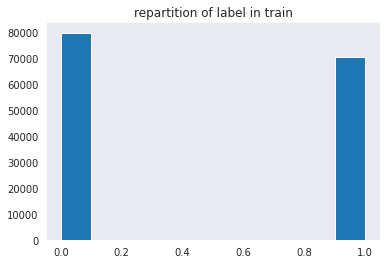

In [16]:
train_labels = pd.read_csv('label_train.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('train')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
#print(filenames[:10])
print("Size of train dataset : {}".format(len(filenames)))
train_filenames = pd.DataFrame(filenames, columns = ['filenames'])
train_df = pd.concat([train_filenames, train_labels], axis=1)
# Add train/ path for show image
train_df_copy = train_df.copy()
train_df_copy['filenames'] = 'train/' + train_df_copy['filenames'].astype(str)
print(train_df_copy)
print(train_df_copy['genre'].value_counts()/len(train_df))
print("\n\n")
print(train_df_copy['label'].value_counts()/len(train_df))

print("\n\nNo duplicate label for same image training : {}\n\n".format(train_df_copy['filenames'].is_unique))

plt.title('repartition of gender in train');
plt.hist(train_df_copy['genre']);
plt.show();
plt.title('repartition of label in train');
plt.hist(train_df_copy['label']);
plt.show();

We can affirm that there is label are little unbalanced as the gender repartition. So this first point may influence our future CNN architecture. 

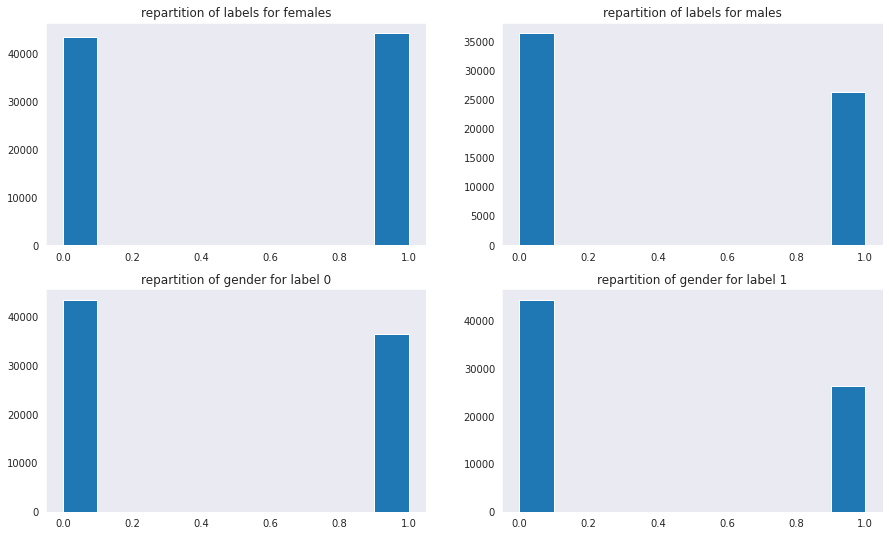

In [20]:
female_train = train_df_copy[train_df_copy['genre'] == 0]
male_train = train_df_copy[train_df_copy['genre'] == 1]
train_label0 = train_df_copy[train_df_copy['label'] == 0]
train_label1 = train_df_copy[train_df_copy['label'] == 1]

plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.title('repartition of labels for females')
plt.hist(female_train["label"])
plt.subplot(2,2,2)
plt.title('repartition of labels for males')
plt.hist(male_train["label"])


plt.subplot(2,2,3)
plt.title('repartition of gender for label 0')
plt.hist(train_label0["genre"])
plt.subplot(2,2,4)
plt.title('repartition of gender for label 1')
plt.hist(train_label1["genre"])

plt.show()

train_label0 = train_label0["filenames"]
train_label1 = train_label1["filenames"]

Now, take a look of label repartition inside each gender. Male label are more unbalanced than for female, so the feature label are mostly differenciable for woman than man.

An other point is that for each label woman are more representating than men. It confirms our previous hypothesis about feature more differenciable for women.

In [18]:
female0_train = female_train[female_train["label"] == 0]["filenames"]
female1_train = female_train[female_train["label"] == 1]["filenames"]
male0_train = male_train[male_train["label"] == 0]["filenames"]
male1_train = male_train[male_train["label"] == 1]["filenames"]

print(female0_train)
print("\n\n")
print(female1_train)
print("\n\n")
print(male0_train)
print("\n\n")
print(male1_train)

0         train/000000.jpg
6         train/000006.jpg
9         train/000009.jpg
11        train/000011.jpg
14        train/000014.jpg
                ...       
149976    train/149976.jpg
149977    train/149977.jpg
149979    train/149979.jpg
149980    train/149980.jpg
149981    train/149981.jpg
Name: filenames, Length: 43255, dtype: object



1         train/000001.jpg
2         train/000002.jpg
16        train/000016.jpg
20        train/000020.jpg
27        train/000027.jpg
                ...       
149950    train/149950.jpg
149951    train/149951.jpg
149963    train/149963.jpg
149970    train/149970.jpg
149971    train/149971.jpg
Name: filenames, Length: 44161, dtype: object



3         train/000003.jpg
8         train/000008.jpg
12        train/000012.jpg
13        train/000013.jpg
15        train/000015.jpg
                ...       
149958    train/149958.jpg
149965    train/149965.jpg
149966    train/149966.jpg
149978    train/149978.jpg
149982    train/149982.jpg
Name: filen


Average train image for : female 0


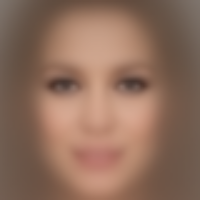


Average train image for : male 0


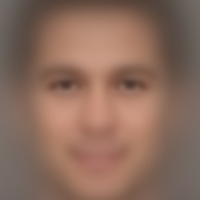


Average train image for : female 1


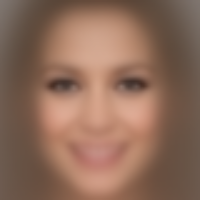


Average train image for : male 1


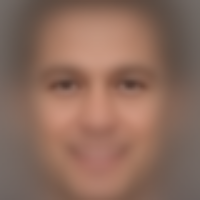

In [19]:
list_train = [female0_train, male0_train, female1_train, male1_train]
list_train_names = ["female 0", "male 0", "female 1", "male 1"]
N = 26000
for k, element in enumerate(list_train):
  # Create a numpy array of floats to store the average (assume RGB images)
  avg=np.zeros((80,80,3),np.float)
  for i in range(N):
    img = cv.imread(element.values[i])
    avg = avg+img/N
    #cv2_imshow(img)
  avg = np.array(np.round(avg),dtype=np.uint8)
  avg_resize= cv.resize(avg, (200, 200))
  print("\nAverage train image for : {}".format(str(list_train_names[k])))
  cv2_imshow(avg_resize)
  plt.show();

Now, we are going to plot the average face image for each label/gender.

> - women are blonder
- men are browner

> - label 0 show neutral face emotion
- label 1 focus on mouth and eye drift corresponding to emotional face


Average train image for : label 0


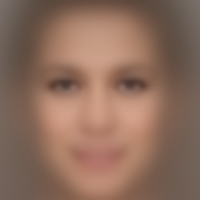


Average train image for : label 1


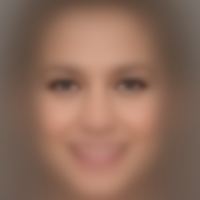


Average Difference train image label 1 - label 0


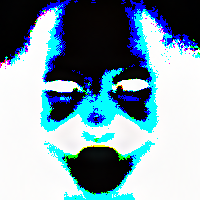


Average Difference train image label 0 - label 1


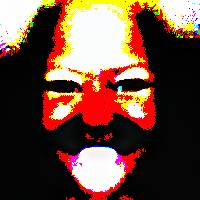

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

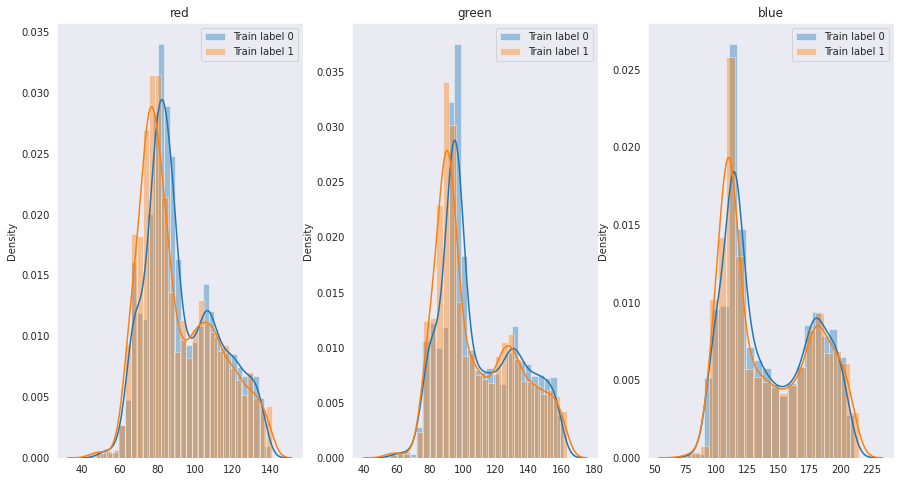

In [21]:
# Initialisation
N = 60000
avg0=np.zeros((80,80,3),np.float)
avg1=np.zeros((80,80,3),np.float)
# Average Image for each label
for i in range(N):
  img0 = cv.imread(train_label0.values[i])
  avg0 = avg0+img0/N
  img1 = cv.imread(train_label1.values[i])
  avg1 = avg1+img1/N
avg0 = np.array(np.round(avg0),dtype=np.uint8)
avg_resize0= cv.resize(avg0, (200, 200))
avg1 = np.array(np.round(avg1),dtype=np.uint8)
avg_resize1= cv.resize(avg1, (200, 200))

# Plot images
print("\nAverage train image for : label 0")
cv2_imshow(avg_resize0)
plt.show();
print("\nAverage train image for : label 1")
cv2_imshow(avg_resize1)
plt.show();
print("\nAverage Difference train image label 1 - label 0")
cv2_imshow(avg_resize1-avg_resize0)
plt.show();
print("\nAverage Difference train image label 0 - label 1")
cv2_imshow(avg_resize0-avg_resize1)
plt.show();

print("\n\n")
# Plot distribution average channel
plt.figure()
colors = ['red','green','blue']
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1);
    plt.title(colors[i]);
    sns.distplot(avg0[:,:,i].reshape(-1).astype(int), label = "Train label 0");
    sns.distplot(avg1[:,:,i].reshape(-1).astype(int), label = "Train label 1");
    plt.legend();
plt.show();

The average difference between label 1 - label 0 focus on mouth / eye and around the face corresponding probably to long hair.

Also channel distribution plots don't show a clearly separable threshold between 2 labels. Maybe we can suppose that channel red is where there is less cover between two distributions.

*Label Images*

Label 0 :


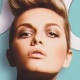

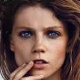

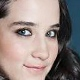

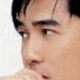

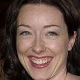

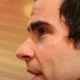

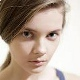

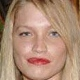

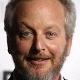

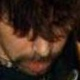




Label 1 :


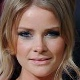

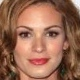

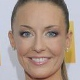

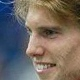

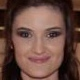

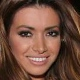

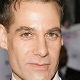

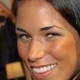

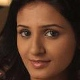

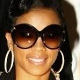

In [22]:
print("Label 0 :")
for i in range(10):
  k = random.randint(1,500)
  img = cv.imread(train_label0.values[i*k])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Label 1 :")
for i in range(10):
  k = random.randint(1,500)
  img = cv.imread(train_label1.values[k*i])
  cv2_imshow(img)
plt.show();

*Genre Images*

Female label 0


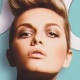

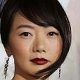

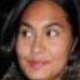

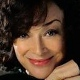

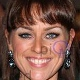

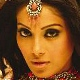

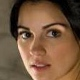

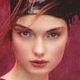

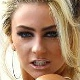

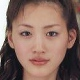




Female label 1


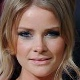

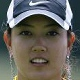

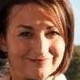

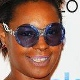

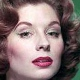

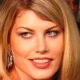

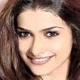

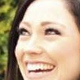

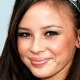

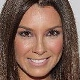




Male label 0


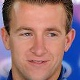

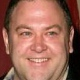

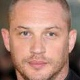

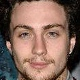

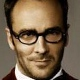

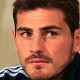

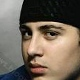

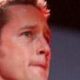

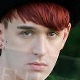

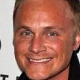




Male label 1


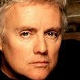

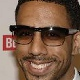

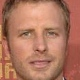

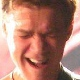

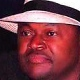

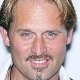

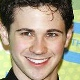

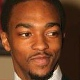

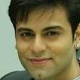

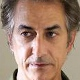

In [23]:
print("Female label 0")
for i in range(10):
  k = random.randint(1,400)
  img = cv.imread(female0_train.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Female label 1")
for i in range(10):
  k = random.randint(1,400)
  img = cv.imread(female1_train.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Male label 0")
for i in range(10):
  k = random.randint(1,400)
  img = cv.imread(male0_train.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Male label 1")
for i in range(10):
  k = random.randint(1,200)
  img = cv.imread(male1_train.values[k*i])
  cv2_imshow(img)
plt.show();

<font color='orange'>**2.2 Validation set** <a name="ValidationDataset"></a></font>

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']
Size of train dataset : 24996
                   filenames  label  genre
0      validation/000000.jpg      1      0
1      validation/000001.jpg      0      1
2      validation/000002.jpg      1      0
3      validation/000003.jpg      1      0
4      validation/000004.jpg      0      1
...                      ...    ...    ...
24991  validation/024991.jpg      1      1
24992  validation/024992.jpg      1      0
24993  validation/024993.jpg      0      0
24994  validation/024994.jpg      1      0
24995  validation/024995.jpg      0      0

[24996 rows x 3 columns]
0    0.584654
1    0.415346
Name: genre, dtype: float64



0    0.533285
1    0.466715
Name: label, dtype: float64


No duplicate label for same image validation : True




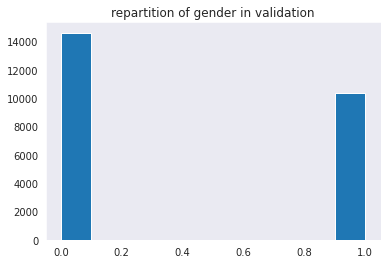

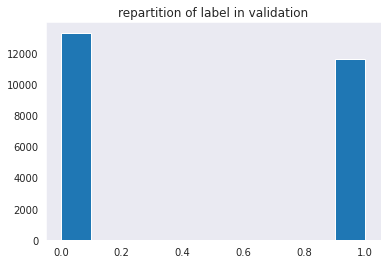

In [24]:
val_labels = pd.read_csv('label_validation.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('validation')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
print(filenames[:10])
print("Size of train dataset : {}".format(len(filenames)))
val_filenames = pd.DataFrame(filenames, columns = ['filenames'])
val_df = pd.concat([val_filenames, val_labels], axis=1)
# Add validation/ path for show image
val_df_copy = val_df.copy()
val_df_copy['filenames'] = 'validation/' + val_df_copy['filenames'].astype(str)
print(val_df_copy)
print(val_df_copy['genre'].value_counts()/len(val_df_copy))
print("\n\n")
print(val_df_copy['label'].value_counts()/len(val_df_copy))

print("\n\nNo duplicate label for same image validation : {}\n\n".format(val_df_copy['filenames'].is_unique))

plt.title('repartition of gender in validation');
plt.hist(val_df_copy['genre']);
plt.show();
plt.title('repartition of label in validation');
plt.hist(val_df_copy['label']);
plt.show();

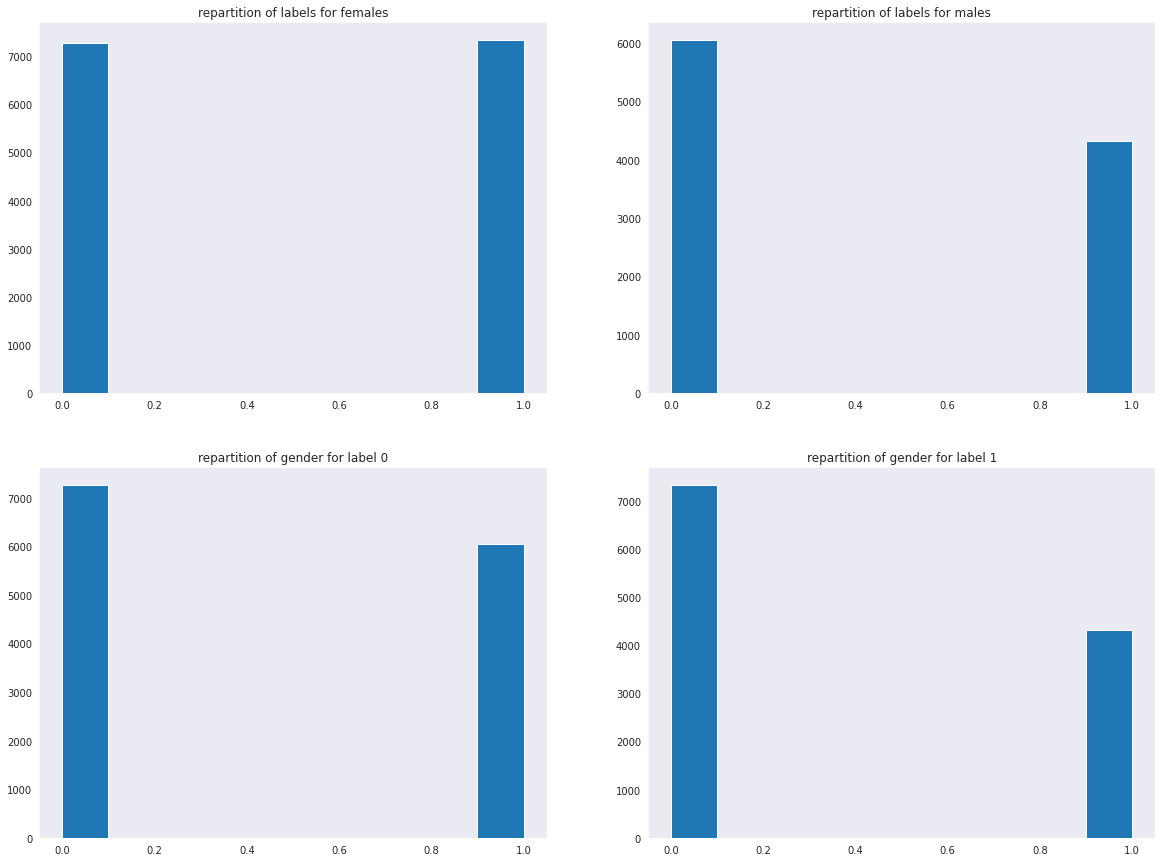

In [25]:
female_val = val_df_copy[val_df_copy['genre'] == 0]
male_val = val_df_copy[val_df_copy['genre'] == 1]
val_label0 = val_df_copy[val_df_copy['label'] == 0]
val_label1 = val_df_copy[val_df_copy['label'] == 1]


plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title('repartition of labels for females')
plt.hist(female_val["label"])
plt.subplot(2,2,2)
plt.title('repartition of labels for males')
plt.hist(male_val["label"])

plt.subplot(2,2,3)
plt.title('repartition of gender for label 0')
plt.hist(val_label0["genre"])
plt.subplot(2,2,4)
plt.title('repartition of gender for label 1')
plt.hist(val_label1["genre"])

plt.show()


val_label0 = val_label0["filenames"]
val_label1 = val_label1["filenames"]

In [26]:
group_by_genre = val_df_copy.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]

female0_val = genre_0[genre_0["label"] == 0]["filenames"]
female1_val = genre_0[genre_0["label"] == 1]["filenames"]
male0_val = genre_1[genre_1["label"] == 0]["filenames"]
male1_val = genre_1[genre_1["label"] == 1]["filenames"]

print(female0_val)
print("\n\n")
print(female1_val)
print("\n\n")
print(male0_val)
print("\n\n")
print(male1_val)

5        validation/000005.jpg
7        validation/000007.jpg
13       validation/000013.jpg
14       validation/000014.jpg
15       validation/000015.jpg
                 ...          
24981    validation/024981.jpg
24988    validation/024988.jpg
24990    validation/024990.jpg
24993    validation/024993.jpg
24995    validation/024995.jpg
Name: filenames, Length: 7272, dtype: object



0        validation/000000.jpg
2        validation/000002.jpg
3        validation/000003.jpg
9        validation/000009.jpg
10       validation/000010.jpg
                 ...          
24982    validation/024982.jpg
24985    validation/024985.jpg
24987    validation/024987.jpg
24992    validation/024992.jpg
24994    validation/024994.jpg
Name: filenames, Length: 7342, dtype: object



1        validation/000001.jpg
4        validation/000004.jpg
6        validation/000006.jpg
8        validation/000008.jpg
35       validation/000035.jpg
                 ...          
24967    validation/024967.jpg
24979


Average validation image for : label 0


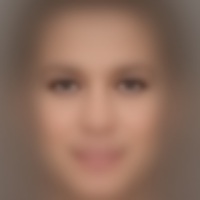


Average validation image for : label 1


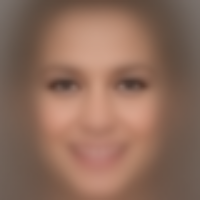

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

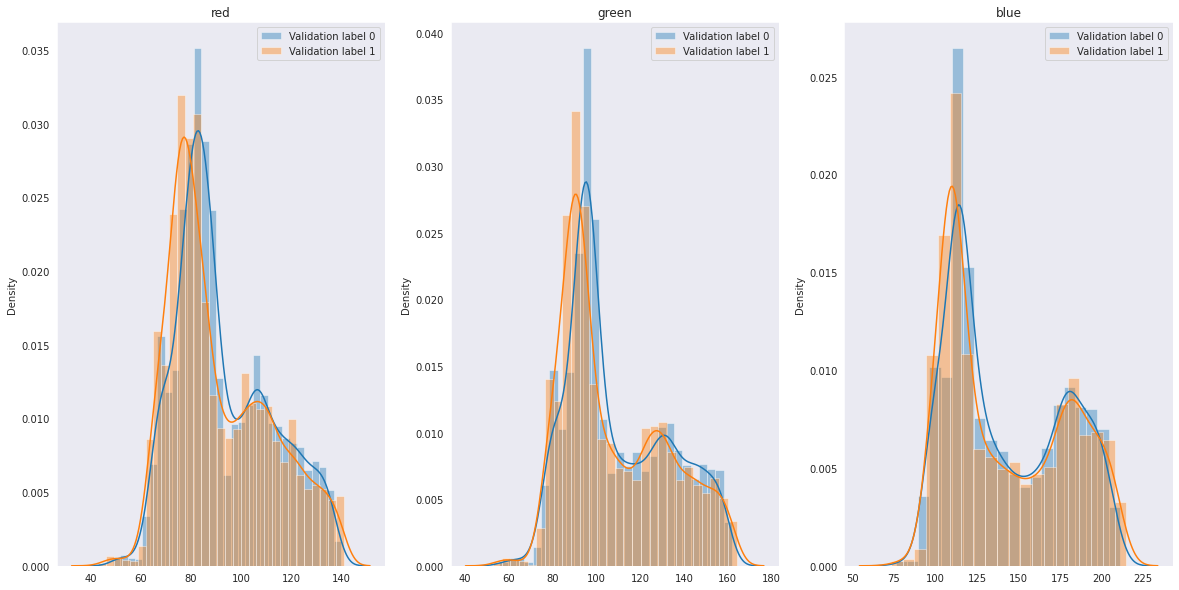

In [27]:
# Initialisation
N = 11000
avg_val0=np.zeros((80,80,3),np.float)
avg_val1=np.zeros((80,80,3),np.float)
# Average Image for each label
for i in range(N):
  img_val0 = cv.imread(val_label0.values[i])
  avg_val0 = avg_val0+img_val0/N
  img_val1 = cv.imread(val_label1.values[i])
  avg_val1 = avg_val1+img_val1/N
avg_val0 = np.array(np.round(avg_val0),dtype=np.uint8)
avg_resize_val0= cv.resize(avg_val0, (200, 200))
avg_val1 = np.array(np.round(avg_val1),dtype=np.uint8)
avg_resize_val1= cv.resize(avg_val1, (200, 200))

# Plot images
print("\nAverage validation image for : label 0")
cv2_imshow(avg_resize_val0)
plt.show();
print("\nAverage validation image for : label 1")
cv2_imshow(avg_resize_val1)
plt.show();
print("\n\n")
# Plot distribution average channel
plt.figure()
colors = ['red','green','blue']
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1,3,i+1);
    plt.title(colors[i]);
    sns.distplot(avg_val0[:,:,i].reshape(-1).astype(int), label = "Validation label 0");
    sns.distplot(avg_val1[:,:,i].reshape(-1).astype(int), label = "Validation label 1");
    plt.legend();
plt.show();

Female label 0


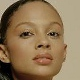

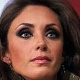

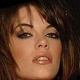

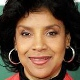

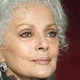

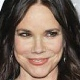

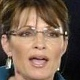

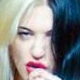

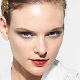

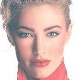




Female label 1


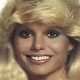

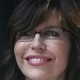

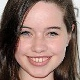

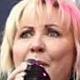

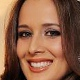

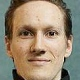

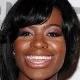

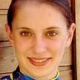

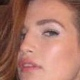

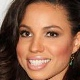




Male label 0


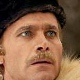

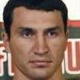

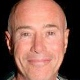

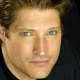

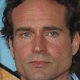

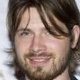

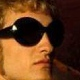

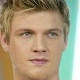

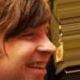

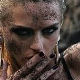




Male label 1


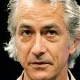

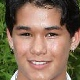

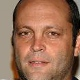

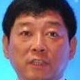

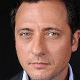

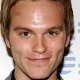

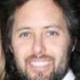

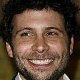

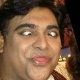

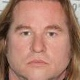

In [28]:
print("Female label 0")
for i in range(10):
  k = random.randint(1,200)
  img = cv.imread(female0_val.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Female label 1")
for i in range(10):
  k = random.randint(1,200)
  img = cv.imread(female1_val.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Male label 0")
for i in range(10):
  k = random.randint(1,200)
  img = cv.imread(male0_val.values[k*i])
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Male label 1")
for i in range(10):
  k = random.randint(1,200)
  img = cv.imread(male1_val.values[k*i])
  cv2_imshow(img)
plt.show();

In validation set we can have the same conclusions as training set.

But if we go deeper we can make other hypothesis that some face seems to be misclassified (some neutral face in label 1 although all others are expressive face)

<font color='orange'>**2.3 Preprocessing : Data Augmentation & Unbalanced class** <a name="Preprocess"></a></font>


The validation set provided is a subset of the train set. Therefore, it is impossible
to rely on the validation score to estimate the accuracy of the model.
The best approaches remains to :

- apply cross validation, average the score on all folds and identify the methodology that performs the best

- weight the loss function according to the initial class imbalance

- do data augmentation on the initial images

- add regularization and drop out to our deep learning models to avoid coadaptation


Data augmentation techniques allow a more robust model but bring some
concern due to the unknown meaning of the label. If the label is a measure
of distance between eyes or a measure of symmetry of the face for example, it
then becomes impossible do to data augmentation since they include rotation or
cropping of the images.

In [29]:
def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
	resized = cv.resize(gray, (hashSize + 1, hashSize))
	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]
	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


[INFO] computing image hashes...
label : 1


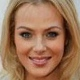

label : 1


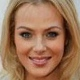

label : 0


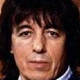

label : 0


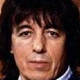

label : 1


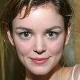

label : 1


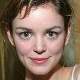

label : 1


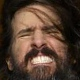

label : 1


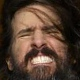

label : 1


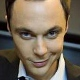

label : 0


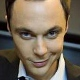

label : 0


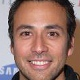

label : 0


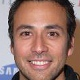

label : 0


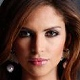

label : 0


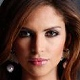

label : 1


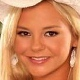

label : 1


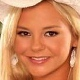

label : 1


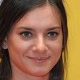

label : 1


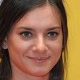

label : 1


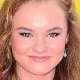

label : 1


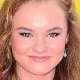

label : 0


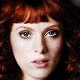

label : 0


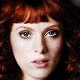

label : 1


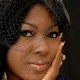

label : 1


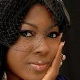

label : 0


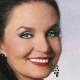

label : 0


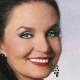

label : 1


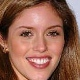

label : 1


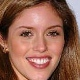

label : 0


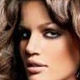

label : 0


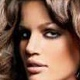

label : 1


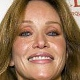

label : 1


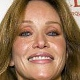

label : 1


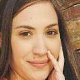

label : 1


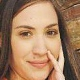

label : 1


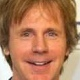

label : 0


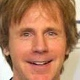

label : 0


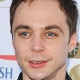

label : 0


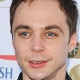

label : 1


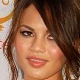

label : 1


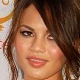

label : 1


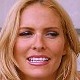

label : 1


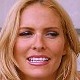

label : 1


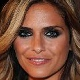

label : 1


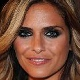

label : 1


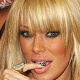

label : 1


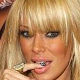

label : 1


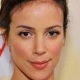

label : 1


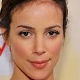

label : 1


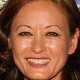

label : 1


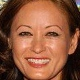

label : 0


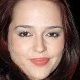

label : 0


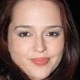

label : 0


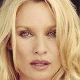

label : 1


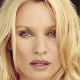

label : 0


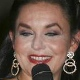

label : 0


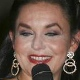

label : 1


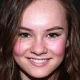

label : 1


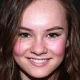

label : 0


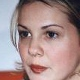

label : 0


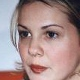

label : 1


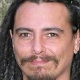

label : 1


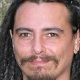

label : 1


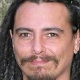

label : 0


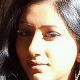

label : 0


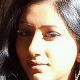

label : 0


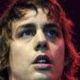

label : 0


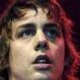

label : 0


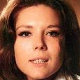

label : 0


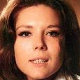

label : 1


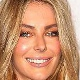

label : 1


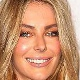

label : 0


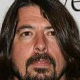

label : 0


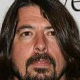

label : 0


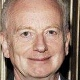

label : 0


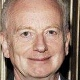

label : 0


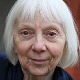

label : 0


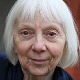

label : 1


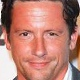

label : 1


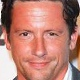

label : 1


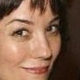

label : 1


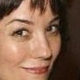

label : 0


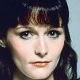

label : 0


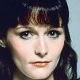

label : 0


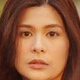

label : 0


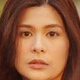

label : 0


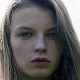

label : 0


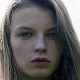

label : 0


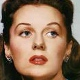

label : 0


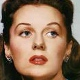

label : 0


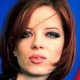

label : 0


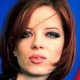

label : 1


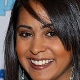

label : 1


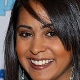

label : 0


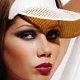

label : 1


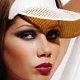

label : 1


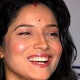

label : 1


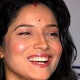

label : 1


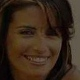

label : 1


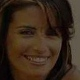

label : 0


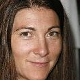

label : 0


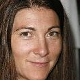

label : 1


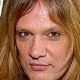

label : 1


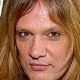

label : 1


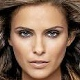

label : 1


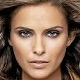

label : 0


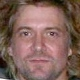

label : 0


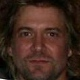

label : 0


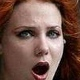

label : 0


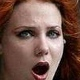

label : 0


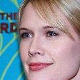

label : 1


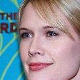

label : 0


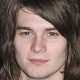

label : 0


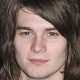

label : 0


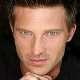

label : 0


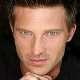

label : 1


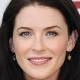

label : 1


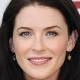

label : 0


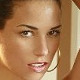

label : 0


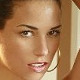

label : 0


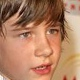

label : 0


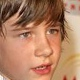

label : 0


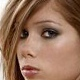

label : 0


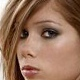

label : 0


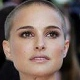

label : 0


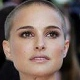

label : 0


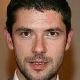

label : 0


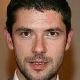

label : 0


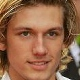

label : 0


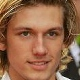

label : 0


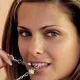

label : 0


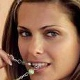

label : 1


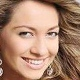

label : 1


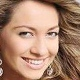

label : 1


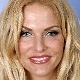

label : 1


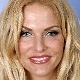

label : 1


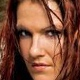

label : 0


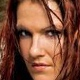

label : 0


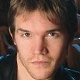

label : 0


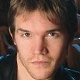

label : 0


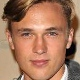

label : 0


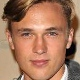

label : 0


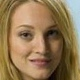

label : 0


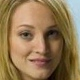

label : 0


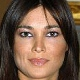

label : 0


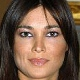

label : 1


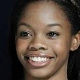

label : 1


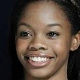

label : 0


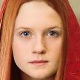

label : 0


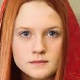

label : 0


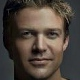

label : 1


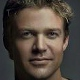

label : 1


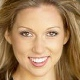

label : 1


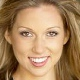

label : 1


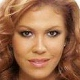

label : 1


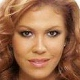

label : 0


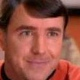

label : 0


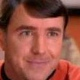

label : 1


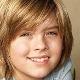

label : 1


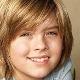

label : 1


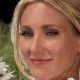

label : 1


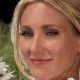

label : 1


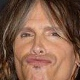

label : 1


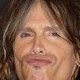

label : 0


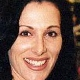

label : 1


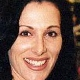

label : 1


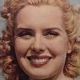

label : 1


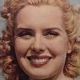

label : 0


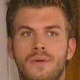

label : 0


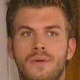

label : 0


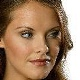

label : 0


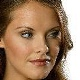

label : 1


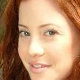

label : 1


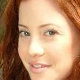

label : 0


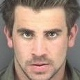

label : 0


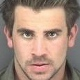

label : 0


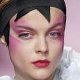

label : 0


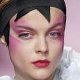

label : 1


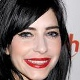

label : 1


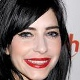

label : 1


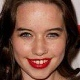

label : 1


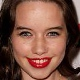

label : 0


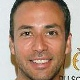

label : 0


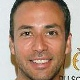

label : 0


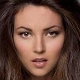

label : 0


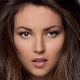

label : 1


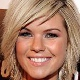

label : 1


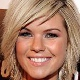

label : 0


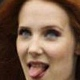

label : 0


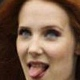

label : 0


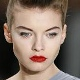

label : 0


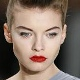

label : 0


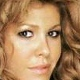

label : 0


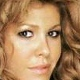

label : 0


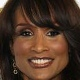

label : 0


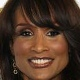

label : 0


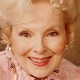

label : 0


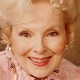

label : 1


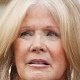

label : 1


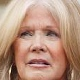

label : 1


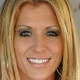

label : 1


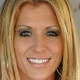

label : 0


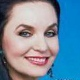

label : 0


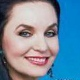

label : 0


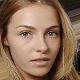

label : 0


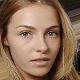

label : 0


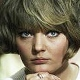

label : 0


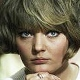

label : 0


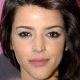

label : 0


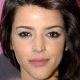

label : 1


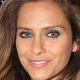

label : 1


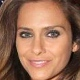

label : 1


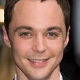

label : 1


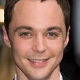

label : 0


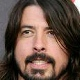

label : 0


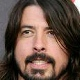

label : 1


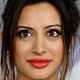

label : 1


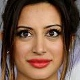

label : 0


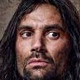

label : 0


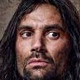

label : 0


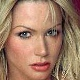

label : 0


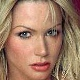

label : 0


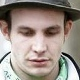

label : 0


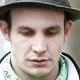

223


In [30]:
# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
hashes = {}
hashedPaths = train_df_copy["filenames"].values
# loop over our image paths
for imagePath in hashedPaths:
	# load the input image and compute the hash
	image = cv.imread(imagePath)
	h = dhash(image)
	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	p = hashes.get(h, [])
	p.append(imagePath)
	hashes[h] = p

train_duplicates = []
for (h, hashedPaths) in hashes.items():
  if len(hashedPaths) > 1 :
    for p in hashedPaths:
      label_toprint = train_df_copy[train_df_copy["filenames"].values == p]["label"].values[0]
      print("label : {}".format(label_toprint))
      image = cv.imread(p)
      cv2_imshow(image)
      plt.show();
      train_duplicates.append(p)
print(len(train_duplicates))

Here we see all duplicate (223), also we print the label corresponding.
Clearly duplicates are in the same label expected for 4 images, that are difficult to classify because the mouth is not totally open or cheekbone not expressiveness.

[INFO] computing image hashes...
label : 0


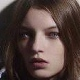

label : 0


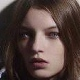

label : 0


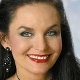

label : 0


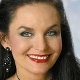

label : 1


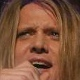

label : 1


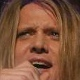

label : 0


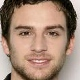

label : 0


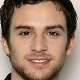

8


In [31]:
# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
hashes_val = {}
hashedPaths_val = val_df_copy["filenames"].values
# loop over our image paths
for imagePath_val in hashedPaths_val:
	# load the input image and compute the hash
	image_val = cv.imread(imagePath_val)
	h_val = dhash(image_val)
	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	p_val = hashes_val.get(h_val, [])
	p_val.append(imagePath_val)
	hashes_val[h_val] = p_val

val_duplicates = []
for (h_val, hashedPaths_val) in hashes_val.items():
  if len(hashedPaths_val) > 1 :
    for p_val in hashedPaths_val:
      label_toprint_val = val_df_copy[val_df_copy["filenames"].values == p_val]["label"].values[0]
      print("label : {}".format(label_toprint_val))
      image_val = cv.imread(p_val)
      cv2_imshow(image_val)
      plt.show();
      val_duplicates.append(p_val)
print(len(val_duplicates))

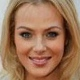

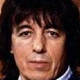

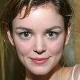

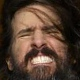

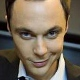

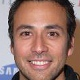

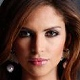

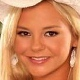

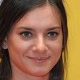

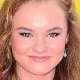

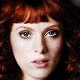

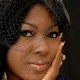

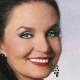

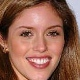

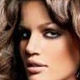

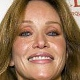

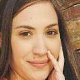

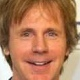

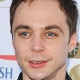

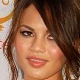

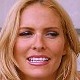

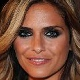

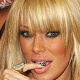

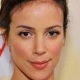

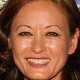

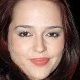

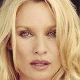

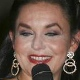

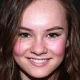

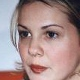

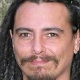

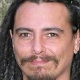

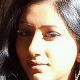

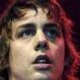

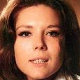

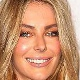

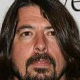

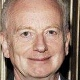

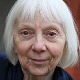

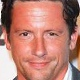

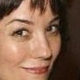

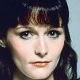

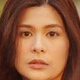

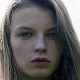

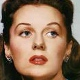

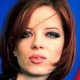

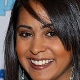

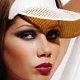

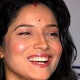

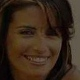

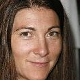

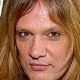

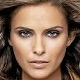

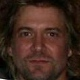

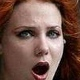

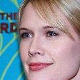

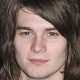

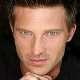

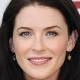

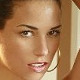

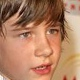

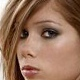

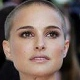

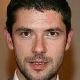

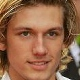

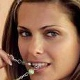

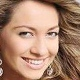

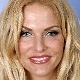

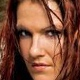

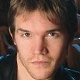

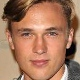

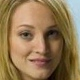

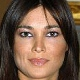

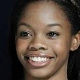

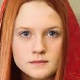

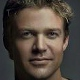

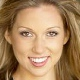

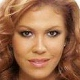

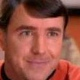

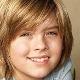

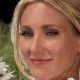

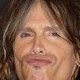

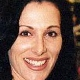

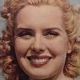

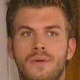

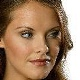

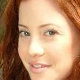

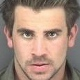

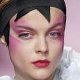

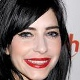

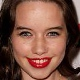

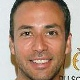

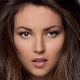

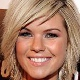

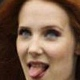

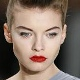

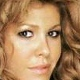

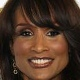

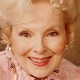

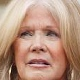

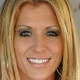

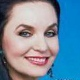

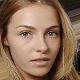

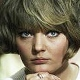

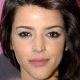

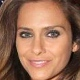

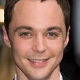

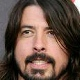

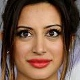

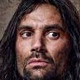

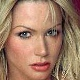

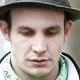

112


In [ ]:
train_duplicates = train_duplicates[::2]
for ele in train_duplicates:
  image = cv.imread(ele)
  cv2_imshow(image)
  plt.show();
  train_df_copy = train_df_copy[~(train_df_copy == ele).any(axis=1)]
print(len(train_duplicates))

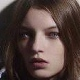

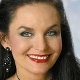

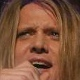

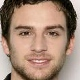

4


In [ ]:
val_duplicates = val_duplicates[::2]
for ele in val_duplicates:
  image = cv.imread(ele)
  cv2_imshow(image)
  plt.show();
  val_df_copy = val_df_copy[~(val_df_copy == ele).any(axis=1)]
print(len(val_duplicates))

In [ ]:
TOTAL_TRAIN_SAMPLES = len(train_df_copy)
TOTAL_VALIDATION_SAMPLES = len(val_df_copy)
print(TOTAL_TRAIN_SAMPLES)
print(TOTAL_VALIDATION_SAMPLES)

149871
24992


After removing duplicate images in train / validation sets.

In [ ]:
train_df

filenames  label  genre
0       000000.jpg      0      0
1       000001.jpg      1      0
2       000002.jpg      1      0
3       000003.jpg      0      1
4       000004.jpg      1      1
...            ...    ...    ...
149978  149978.jpg      0      1
149979  149979.jpg      0      0
149980  149980.jpg      0      0
149981  149981.jpg      0      0
149982  149982.jpg      0      1

[149983 rows x 3 columns]

In [32]:
unbalanced_0 = (train_df['label'].value_counts()/len(train_df))[0]
unbalanced_1 = (train_df['label'].value_counts()/len(train_df))[1]

class_weight = {0: unbalanced_0, 1: unbalanced_1}
class_weight

{0: 0.5309468406419394, 1: 0.4690531593580606}

In [33]:
data_augmentation = keras.Sequential(
    [
        RandomFlip(seed=42),
        RandomRotation(0.1, seed=42),
        RandomTranslation(0.1, 0.1, seed=42),
        Resizing(200, 200, interpolation='nearest')
    ]
)

# **3. Modelisation** <a name="DL"></a>

<font color='orange'>**Architectures** <a name="Architectures"></a></font>

First I try the basic model given that corresponding to lenet architecture presented in LeCun article.

The main difference is in this case we use MaxPooling better for feature extraction because more differenciable than Averaging (smoother).

After that I test DenseNet / ResNet architectures but I implement more specific architectures. 
Xception model that present a part of recursivity and a Bknet architecture found after searching papers about face emotion classification.

*Lenet*


In [34]:
def Lenet(input_shape):
  # Basic model given -> Lenet with MaxPooling instead of Average
  lenet = keras.models.Sequential()
  lenet.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=input_shape))
  lenet.add(layers.MaxPooling2D((2, 2)))
  lenet.add(layers.Conv2D(64, (3, 3), activation='relu'))
  lenet.add(layers.MaxPooling2D((2, 2)))

  lenet.add(layers.Conv2D(128, (3, 3), activation='relu'))
  lenet.add(layers.MaxPooling2D((2, 2)))
  lenet.add(layers.Conv2D(256, (3, 3), activation='relu'))
  lenet.add(layers.MaxPooling2D((2, 2)))

  lenet.add(layers.Flatten())
  lenet.add(layers.Dense(512, activation='relu'))
  lenet.add(layers.Dense(1, activation='sigmoid'))
  return lenet

*XCeption*

This is an extract of Xception architecture which there is a recursivity 8 times loop in Middle flow.


![Xception](https://s1.qwant.com/thumbr/0x380/2/0/3f3e370bac8e494373a7ceb8f2399ca12b1d6804bf725c74f2a209b92b7904/1*hOcAEj9QzqgBXcwUzmEvSg.png?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1600%2F1*hOcAEj9QzqgBXcwUzmEvSg.png&q=0&b=1&p=0&a=0)

In [36]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = Add()([x, residual])
        previous_block_activation = x

    return x

def middle_flow(x) :

    previous_block_activation = x

    for _ in range(8) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)

    return x

*BKNet*

Here is the schema of Bknet architecture basically used for classify gender, age, and smile faces.

At the it used 3 double Fully Connected (FC) layers for each feature in our case we only used one and change softmax output probabilities by a sigmoid FC.

Also our main problem in this study is the overfitting risk with non uniform faces and some misclassified. So to avoid it I put Dropout layers after each MaxPooling and between the last two FC with a 0.1 factor. I try with a L2/L1 kernel regularization but not with significant effect.

![BKNET](https://s1.qwant.com/thumbr/0x380/9/b/21e5924c743f85bc3e8a429906b98ad2026805a1a497bd247b1afbdf987a64/BKNet-architecture-12.png?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FGiang_Son_Tran%2Fpublication%2F324549019%2Ffigure%2Ffig3%2FAS%3A649929156468736%401531966594330%2FBKNet-architecture-12.png&q=0&b=1&p=0&a=0)

In [44]:
###
# BKNet
###

tf.keras.regularizers.L1(l1=0.05)

tf.keras.regularizers.L1L2(l1=0.01, l2=0.02)

tf.keras.regularizers.L2(l2=0.1)

def Bknet(input_shape):
  bknet = keras.models.Sequential()
  ##
  bknet.add(layers.Conv2D(32, (3, 3),activation='relu',input_shape=input_shape)) #kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.Conv2D(32, (3, 3),activation='relu')) #,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.MaxPooling2D((2, 2)))

  #Try with a dropout
  bknet.add(layers.Dropout(0.1))
  #

  ##
  bknet.add(layers.Conv2D(64, (3, 3),activation='relu'))#, kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.Conv2D(64, (3, 3),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.MaxPooling2D((2, 2)))

  #Try with a dropout
  bknet.add(layers.Dropout(0.1))
  #

  ##
  bknet.add(layers.Conv2D(128, (3, 3),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.Conv2D(128, (3, 3),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.MaxPooling2D((2, 2)))

  #Try with a dropout
  bknet.add(layers.Dropout(0.1))
  #

  ##
  bknet.add(layers.Conv2D(256, (3, 3),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.Conv2D(256, (3, 3),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.Conv2D(256, (1, 1),activation='relu'))#,kernel_regularizer='l2'))
  bknet.add(layers.BatchNormalization())
  bknet.add(layers.MaxPooling2D((2, 2)))

  #Try with a dropout
  bknet.add(layers.Dropout(0.1))
  #
  
  bknet.add(layers.Flatten())
  bknet.add(layers.Dense(512, activation='relu'))

  bknet.add(layers.Dropout(0.1))

  bknet.add(layers.Dense(512, activation='relu'))
  bknet.add(layers.Dense(1, activation='sigmoid'))
  return bknet

-----------

### **Training**

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

genki_train_datagen = ImageDataGenerator(rescale=1./255)
genki_valid_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
train_df_copy1 = train_df_copy.copy()
train_df_copy1["filenames"] = train_df_copy1["filenames"].str[6:]

val_df_copy1 = val_df_copy.copy()
val_df_copy1["filenames"] = val_df_copy1["filenames"].str[11:]

print(train_df_copy1)
print("\n\n")
print(val_df_copy1)
print("\n\n")
print(genki_images)

         filenames  label  genre
0       000000.jpg      0      0
1       000001.jpg      1      0
2       000002.jpg      1      0
3       000003.jpg      0      1
4       000004.jpg      1      1
...            ...    ...    ...
149978  149978.jpg      0      1
149979  149979.jpg      0      0
149980  149980.jpg      0      0
149981  149981.jpg      0      0
149982  149982.jpg      0      1

[149983 rows x 3 columns]



        filenames  label  genre
0      000000.jpg      1      0
1      000001.jpg      0      1
2      000002.jpg      1      0
3      000003.jpg      1      0
4      000004.jpg      0      1
...           ...    ...    ...
24991  024991.jpg      1      1
24992  024992.jpg      1      0
24993  024993.jpg      0      0
24994  024994.jpg      1      0
24995  024995.jpg      0      0

[24996 rows x 3 columns]



         filenames  labels
0     file0001.jpg       1
1     file0002.jpg       1
2     file0003.jpg       1
3     file0004.jpg       1
4     file0005.jpg       1

In [40]:
# Carefull between copy dataframe with preprocessing or not
BATCH_SIZE = 128

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train",
    x_col="filenames",
    y_col= ['label'],
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=(80, 80),
    class_mode="raw")

val_generator=val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="validation",
    x_col="filenames",
    y_col= ['label'],
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=(80, 80),
    class_mode="raw")

Found 149983 validated image filenames.
Found 24996 validated image filenames.


In [41]:
# Augmented generator 
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=10,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             zoom_range=0.2,
                                             horizontal_flip=True,
                                             vertical_flip=False,
                                             fill_mode='nearest')

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    dataframe=train_df,
    directory="train",
    x_col="filenames",
    y_col= ['label'],
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=(80, 80),
    class_mode="raw")

# GENKI TL dataset
genki_train_generator=genki_train_datagen.flow_from_dataframe(dataframe=genki_images,
                                                              directory="GENKI-4K/files",
                                                              x_col="filenames",
                                                              y_col= ['labels'],
                                                              batch_size=BATCH_SIZE,
                                                              seed=42,
                                                              target_size=(80, 80),
                                                              class_mode="raw")


Found 149983 validated image filenames.
Found 4000 validated image filenames.


Here I try Data Augmentation to avoid overfitting problem but not given an impactfull effect.

In [42]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 80, 80, 3)
labels batch shape: (128, 1)


### **Models compile & fit**

Epoch 1/7
300/300 [==============================] - 44s 87ms/step - loss: 0.6764 - acc: 0.5852 - val_loss: 0.6876 - val_acc: 0.5390
Epoch 2/7
300/300 [==============================] - 26s 85ms/step - loss: 0.5731 - acc: 0.6895 - val_loss: 0.5507 - val_acc: 0.6985
Epoch 3/7
300/300 [==============================] - 25s 84ms/step - loss: 0.5382 - acc: 0.7171 - val_loss: 0.5443 - val_acc: 0.7157
Epoch 4/7
300/300 [==============================] - 26s 85ms/step - loss: 0.5210 - acc: 0.7275 - val_loss: 0.5116 - val_acc: 0.7374
Epoch 5/7
300/300 [==============================] - 25s 84ms/step - loss: 0.5051 - acc: 0.7438 - val_loss: 0.5194 - val_acc: 0.7329
Epoch 6/7
300/300 [==============================] - 25s 83ms/step - loss: 0.4985 - acc: 0.7444 - val_loss: 0.5077 - val_acc: 0.7487
Epoch 7/7
300/300 [==============================] - 25s 83ms/step - loss: 0.4994 - acc: 0.7483 - val_loss: 0.5665 - val_acc: 0.6920


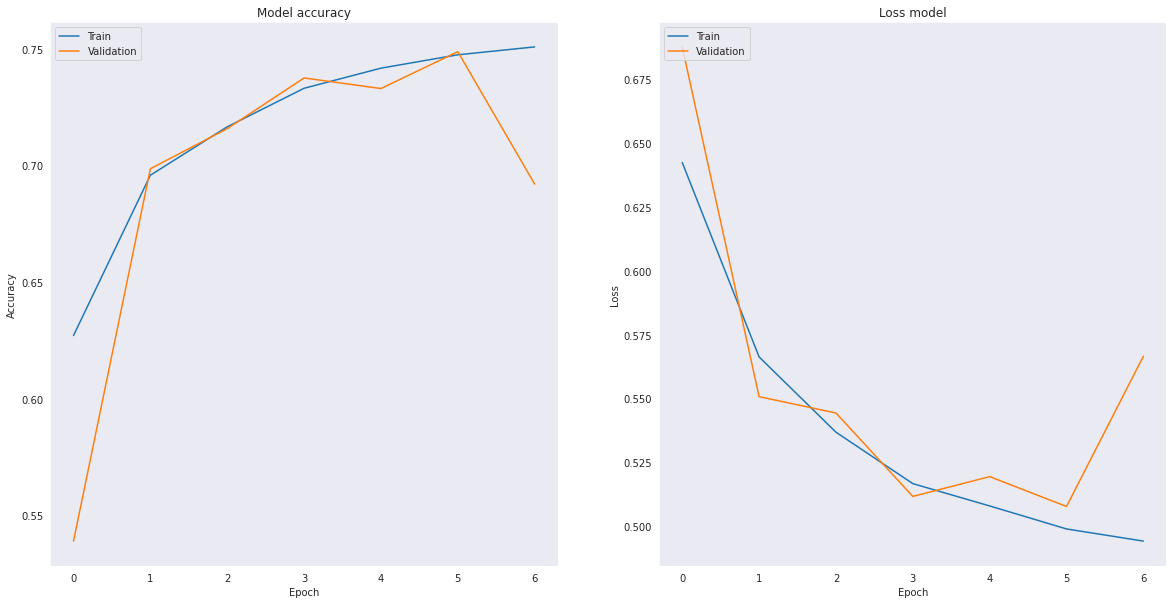

In [45]:
# Replace with name of module to compile @ fit
# bknet80 = Bknet(FACE_SHAPE)

unbalanced_male = (train_df['genre'].value_counts()/len(train_df))[0]
unbalanced_female = (train_df['genre'].value_counts()/len(train_df))[1]

class_weight_gender = {1: unbalanced_female, 0: unbalanced_male}
class_weight_gender

# earlystop will be applied for where there is no improvement 
# in validation loss upto 3 epochs
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

#reduce_lr will also monitor the validation loss 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


callbacks = [earlystop, reduce_lr]

###
# Models to test
###

bknet = Bknet(FACE_SHAPE)

#lenet = Lenet(FACE_SHAPE)

#inputs = Input(FACE_SHAPE)
#outputs = exit_flow(middle_flow(entry_flow(inputs)))
#xception = Model(inputs, outputs)
###

bknet.compile(loss='binary_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-07),
                    metrics=['acc'])

history = bknet.fit(train_generator,
                    #class_weight=class_weight_gender,
                    steps_per_epoch=TOTAL_TRAIN_SAMPLES//BATCH_SIZE,
                    epochs=7,
                    validation_data=val_generator,
                    validation_steps=TOTAL_VALIDATION_SAMPLES//BATCH_SIZE
                    callbacks=callbacks
                    )

# Save model
#lenet.save('Data_Challenge_MDI_341_lenet.h5')

# Plot Accurancy & Loss
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here I try 5 architectures with also some variant especially for BKNET model.

> I implement EarlyStopping and ReduceLROnPlateau to avoid overfitting by stopping training model in case of validation loss stabilize during 3 epochs following or in case of plateau such as gradient stuck on local minima by changing learning rate.

> I optimize model fiting, especially steps per epoch and validation steps by sizing it depending on batch size and dataset size. Models are train on 10 epochs for the benchmark study and on 20 epochs for submission training.

> I select Adam optimizer that is more appropriate for large enough dataset by avoiding too much calculus and ressources. It is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. I try $\beta_1$=0,8 / 0,9 (default) and $\beta_2$=0,9 / 0,99 (default). For submission I use defaults parameters. (https://www.geeksforgeeks.org/intuition-of-adam-optimizer/)


<font color='orange'>**Transfer Learning** <a name="Transfer"></a></font>

For this part I try different approches one is based on GENKI dataset of neutral / smiling faces and I also try with Keras pre-trained models on imagenet and transfer to ou study. But don't found a suitable model to make a good transfer learning approch.

In [ ]:
# Configure the dataset for performance
vgg19 = tf.keras.applications.VGG19(input_shape=(80,80,3),
                                               include_top=False,
                                               weights='imagenet')
## Replace with name of module to compile @ fit
vgg19.compile(loss='binary_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-07),
                    metrics=['acc'])
"""
tl_history = vgg19.fit(train_generator,
                          #class_weight=class_weight,
                          steps_per_epoch=100,
                          epochs=20,
                          validation_data=val_generator,
                          validation_steps=100)

tl_history = bknetGENKI.fit(train_generator,
                    steps_per_epoch=500,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=100)
"""

# **4. Validation DataSet (Accuray by gender)** <a name="Validation"></a>

In [ ]:
val_generator.reset()
pred=bknet.predict(val_generator)
pred
# You can change this Threshold
THRESHOLD = 0.5
pred_bool = (pred > THRESHOLD) * 1
pred_bool

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
val_results=pd.DataFrame(pred_bool, columns= ['score'])
concat_val_results = pd.concat([val_df, val_results], axis = 1)
print(concat_val_results)
print("\n\n\n")
group_by_genre = concat_val_results.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
print("Group 0")
print(genre_0)
print("\n\n\n")
print("Group 1")
print(genre_1)
print("\n\n\n")
accuracy_score_genre_0 = accuracy_score(genre_0['label'], genre_0['score'])
accuracy_score_genre_1 = accuracy_score(genre_1['label'], genre_1['score'])
print('Accuracy_score genre_0: ' , accuracy_score_genre_0)
print('Accuracy_score genre_1: ' , accuracy_score_genre_1)
print("\n\n\n")
print("Classification Error : {}".format(accuracy_score(concat_val_results["label"], concat_val_results["score"])))
print('Classification gender Error : {}'.format(abs(accuracy_score_genre_0-accuracy_score_genre_1)))

        filenames  label  genre  score
0      000000.jpg      1      0      0
1      000001.jpg      0      1      1
2      000002.jpg      1      0      0
3      000003.jpg      1      0      1
4      000004.jpg      0      1      0
...           ...    ...    ...    ...
24991  024991.jpg      1      1      1
24992  024992.jpg      1      0      0
24993  024993.jpg      0      0      0
24994  024994.jpg      1      0      0
24995  024995.jpg      0      0      1

[24996 rows x 4 columns]




Group 0
        filenames  label  genre  score
0      000000.jpg      1      0      0
2      000002.jpg      1      0      0
3      000003.jpg      1      0      1
5      000005.jpg      0      0      1
7      000007.jpg      0      0      1
...           ...    ...    ...    ...
24990  024990.jpg      0      0      0
24992  024992.jpg      1      0      0
24993  024993.jpg      0      0      0
24994  024994.jpg      1      0      0
24995  024995.jpg      0      0      1

[14614 rows x 4 columns]


In [ ]:
error_val = concat_val_results[concat_val_results["label"] != concat_val_results["score"]]
error_val_copy = error_val.copy()
error_val_copy['filenames'] = 'validation/' + error_val_copy['filenames'].astype(str)
good_val = concat_val_results[concat_val_results["label"] == concat_val_results["score"]]
good_val_copy = good_val.copy()
good_val_copy['filenames'] = 'validation/' + good_val_copy['filenames'].astype(str)

female_error = error_val_copy[error_val_copy['genre'] == 0]
male_error = error_val_copy[error_val_copy['genre'] == 1]
print(female_error.shape)
print(male_error.shape)

(2622, 4)
(2889, 4)


In [ ]:
error_val_copy["label"].sum()

3187


Average train image for : avgmale_resize


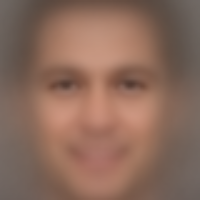


Average train image for : avgfemale_resize


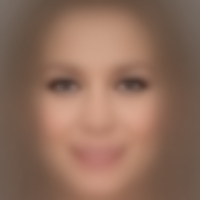

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

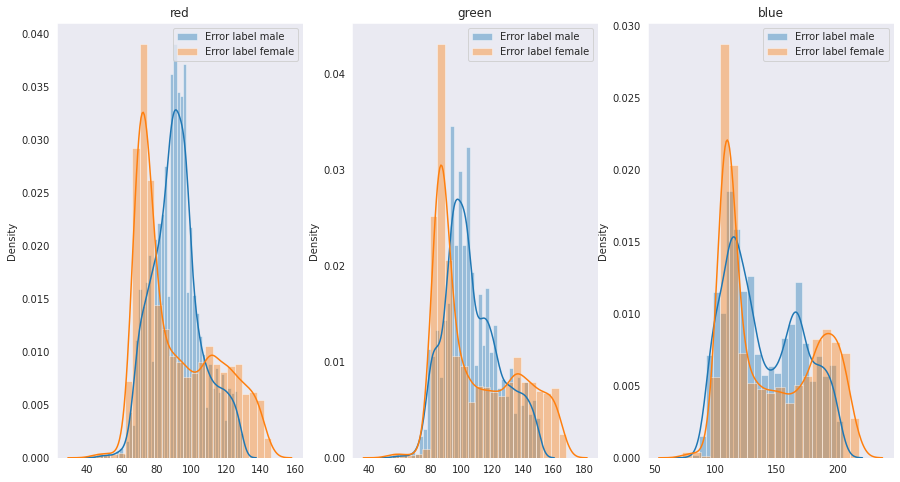

In [ ]:
# Initialisation
N = 2500
avgmale=np.zeros((80,80,3),np.float)
avgfemale=np.zeros((80,80,3),np.float)
# Average Image for each label
for i in range(N):
  imgmale = cv.imread(male_error["filenames"].values[i])
  avgmale = avgmale+imgmale/N
  imgfemale = cv.imread(female_error["filenames"].values[i])
  avgfemale = avgfemale+imgfemale/N
avgmale = np.array(np.round(avgmale),dtype=np.uint8)
avgmale_resize= cv.resize(avgmale, (200, 200))
avgfemale = np.array(np.round(avgfemale),dtype=np.uint8)
avgfemale_resize= cv.resize(avgfemale, (200, 200))

# Plot images
print("\nAverage train image for : avgmale_resize")
cv2_imshow(avgmale_resize)
plt.show();
print("\nAverage train image for : avgfemale_resize")
cv2_imshow(avgfemale_resize)
plt.show();
print("\n\n")
# Plot distribution average channel
plt.figure()
colors = ['red','green','blue']
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1);
    plt.title(colors[i]);
    sns.distplot(avgmale[:,:,i].reshape(-1).astype(int), label = "Error label male");
    sns.distplot(avgfemale[:,:,i].reshape(-1).astype(int), label = "Error label female");
    plt.legend();
plt.show();

label : 0


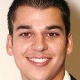

label : 1


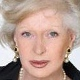

label : 1


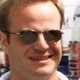

label : 1


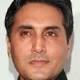

label : 1


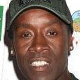

label : 0


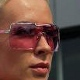

label : 1


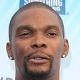

label : 1


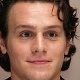

label : 0


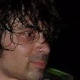

label : 1


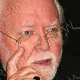

label : 0


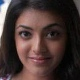

label : 1


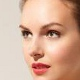

label : 1


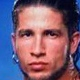

label : 1


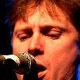

label : 0


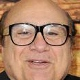

label : 1


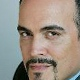

label : 1


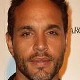

label : 0


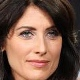

label : 0


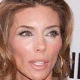

label : 0


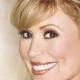




Error classification image


In [ ]:
for i in range(20):
  k = random.randint(1,200)
  img = cv.imread(error_val_copy["filenames"].values[k*i])
  print("label : {}".format(error_val_copy["label"].values[k*i]))
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Error classification image")

label : 1


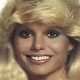

label : 1


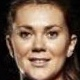

label : 1


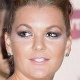

label : 0


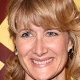

label : 1


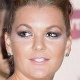

label : 0


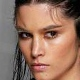

label : 0


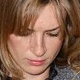

label : 0


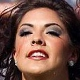

label : 0


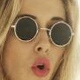

label : 1


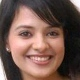

label : 0


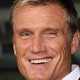

label : 0


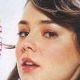

label : 1


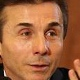

label : 1


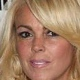

label : 0


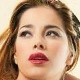

label : 0


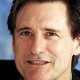

label : 0


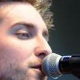

label : 0


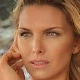

label : 1


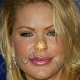

label : 0


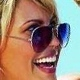




Good classification image


In [ ]:
for i in range(20):
  k = random.randint(1,200)
  img = cv.imread(good_val_copy["filenames"].values[k*i])
  print("label : {}".format(good_val_copy["label"].values[k*i]))
  cv2_imshow(img)
plt.show();
print("\n\n")
print("Good classification image")

Try Grad-CAM for direction gradient help on DNN

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
from tensorflow import keras
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Prepare image
#img_array = preprocess_input(get_img_array(img_path, size=img_size))

img_array = cv.imread('train/000000.jpg')
print(img_array.shape)


# Make model
#model_builder = keras.applications.xception.Xception
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
bknet.layers[-1].activation = None

# Print what the top predicted class is
preds = bknet.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

last_conv_layer_name = "conv2d_356"
last_conv_layer_name = "block14_sepconv2_act"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
      self.layerName = self.find_target_layer()


  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
  		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
  
    # compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
  		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)


# **5. Test submission** <a name="Submission"></a>

In [ ]:
filenames = os.listdir('test')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
print(filenames[:10])
print(len(filenames))
test_filenames = pd.DataFrame(filenames, columns = ['filenames'])

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']
27596


In [ ]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_filenames,
directory="test",
x_col="filenames",
y_col = None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(80,80))

Found 27596 validated image filenames.


In [ ]:
test_generator.reset()
pred=bknet.predict(test_generator)
pred

array([[0.04493031],
       [0.8437147 ],
       [0.91940683],
       ...,
       [0.7124441 ],
       [0.1656869 ],
       [0.5850883 ]], dtype=float32)

In [ ]:
# You can change your threshold
pred_bool_1 = (pred > THRESHOLD) * 1
pred_bool_1

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
### SUBMISSIONS ###
results=pd.DataFrame(pred_bool_1, columns= ['score'])
results.to_csv("Data_Challenge_MDI_341_bknet_dropout_0_7869259.csv", header = None, index = None)

# 6. CONCLUSION <a name="Conclusion"></a>

**So now that I have explored many strategies, let's detailed and sum up**

This is a little recap on different approches tested based on benchmark  set : Adam optimizer with $\beta_1$=0,8 and $\beta_2$=0,9 lr=1e-4, with 500 stepds/epochs, 10 epochs and validation steps = 100.

| Model(s) | Classification Rate | Error classification gender |
|-------------|-------------:|-------------:|
| Lenet | 0.721035 | 0.140811|
| ResNet | 0.73035 | 0.13626
| DenseNet | 0.731717 | 0.11733
| XCeption | 0.747319 | 0.10209
| BKNET | 0.756040 | 0.10992
| Transfer Learning based on GENKI dataset | 0.6039 | 0.1085

I also try to learn models on GENKI dataset based on non-smile / smile faces but too small (only 4000 images) that is undersize than our dataset of 150000 training / 25000 validation faces.

I try data augmentation when creating DataGenerator with some flip, rotation ... but not so efficient.

My final submission is focus on an optimizing steps per epoch depend on batch size with callbacks functions : ReduceLROnPlateau and EarlyStopping to prevent from overfitting.
I focus on BKNET architecture personnalize with Dropout and try to add another layer of Conv2D.

My result where :
Classification Error = 0.213654152776	
Classification Error Gender = 0.0797757243803


<br>

**Overture :** I think that another point that I don't explore is to crop faces and avoid some faces with strong background. Also I don't have enough time but I begin to explore Grad-CAM method to focus attention gradient and could avoid overfitting by focus our model and gradient descent calculus on efficient features as mouth/eye/cheekbone ...
Finally an other point don't explore enough is work on channel transformation RGB to HSV or grayscale histogram normalization etc ... 


# REFERENCES <a name="References"></a>

- **Smile detection in the wild based on transfer learning :** https://arxiv.org/pdf/1802.02185.pdf

- **REAL-TIME SMILE DETECTION USING DEEP LEARNING :** https://core.ac.uk/download/pdf/229076563.pdf

- **Directing DNNs Attention for Facial Attribution Classification using Gradient-weighted Class Activation Mapping :** http://export.arxiv.org/pdf/1905.00593

- **Facial Expressions Classification by Convolutional Neural Network  :** http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2020/paper/ABCs2020_paper_v2_98.pdf

- **Real-Time gender and emotion classification** : https://github.com/oarriaga/face_classification/blob/master/report.pdf

- **Deep Colorization for Facial Gender Recognition** : https://www.ai.rug.nl/~mwiering/GROUP/ARTICLES/Facial_Gender_Classification.pdf

- **Gender and Smile Classification using Deep Convolutional Neural Networks :** https://www.cv-foundation.org/openaccess/content_cvpr_2016_workshops/w18/papers/Zhang_Gender_and_Smile_CVPR_2016_paper.pdf




